In [2]:
#@title Bibliotecas padrões
import pandas as pd
import pandas.io.sql as sqlio
import sys
import psycopg2
from ydata_profiling import ProfileReport
import numpy as np
from botocore import UNSIGNED
from botocore.config import Config
from urllib.parse import quote_plus
from pyathena import connect
import boto3
import boto3.session
from botocore import exceptions
import plotly.express as px

#Carregando as bibliotecas necessárias para a análise estatística
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample

In [3]:
#ponte de conexão com o redshift
connection = psycopg2.connect(dbname="dw_amorsaude",
                  user="gabriel_guilherme",
                  password="PgQ1yBg9hzHJfmc",
                  host ="amorsaude-cluster-redshift.cmc4ev2oyczd.us-east-1.redshift.amazonaws.com",
                  port = 5439)

In [4]:
#df = pd.read_sql_query(df_emails,con=connection)

In [87]:
# Carregando o arquivo Excel em um DataFrame
dfrelatorio_atendimento = pd.read_excel('/home/gabriel/dbt-projects/python_files/analises/files/Relatorio_Atendimentos - Uberlândia 2609 1.xlsx')
dfrelatorio_atendimento

,CLIENTE,SENHA,TIPO ATENDIMENTO,DATA,EMISSAO,TEMPO ESPERA,TEMPO ATENDIMENTO,TEMPO TOTAL,ATENDENTE,LOCAL,Unnamed: 10
0,Franscisneida Maria Do Socorro Alarcao,O3,DR. BRYANN NASCIMENTO TORRECILLA,2023-09-26,11:07:06,00:35:50,00:00:00,00:00:00,Dra.Catia Fernandes Moreira,CONSULTÓRIO-01,Consultórios
1,\tgabrielly Texeira De Sousa,M105,DRA. DIEGO UMBERTO DE MENDONÃ‡A BIASI,2023-09-26,10:31:26,00:34:32,00:04:52,00:39:24,Dr. Diego Umberto De Mendonca Biasi,CONSULTÓRIO-1,Consultórios
2,\tjaquelaine Batisa Da Silva,M120,DRA. DIEGO UMBERTO DE MENDONÃ‡A BIASI,2023-09-26,11:06:06,00:24:51,00:05:00,00:29:51,Dr. Diego Umberto De Mendonca Biasi,CONSULTÓRIO-1,Consultórios
3,\tmaria Jose,P5,DRA. DIEGO UMBERTO DE MENDONÃ‡A BIASI,2023-09-26,08:41:39,01:36:35,00:05:41,01:42:16,Dr. Diego Umberto De Mendonca Biasi,CONSULTÓRIO-1,Consultórios
4,Ana Clara Porto De Sa,M137,DRA. DIEGO UMBERTO DE MENDONÃ‡A BIASI,2023-09-26,11:54:38,00:06:22,00:05:18,00:11:40,Dr. Diego Umberto De Mendonca Biasi,CONSULTÓRIO-1,Consultórios
...,...,...,...,...,...,...,...,...,...,...,...
626,Silvia Maria Pontes Soares,M148,DR.FRANSERGIO FERREIRA,2023-09-26,13:28:02,00:01:26,00:02:24,00:03:50,Millena Misael,TRIAGEM-1,Triagem
627,Taissa Alves Santos,M128,DR. RENATO LEONI,2023-09-26,11:24:45,00:17:29,00:00:15,00:17:44,Millena Misael,TRIAGEM-1,Triagem
628,Tiago De Moura Periolo,M20,DRA. ANGELA FERNANDA,2023-09-26,08:06:50,00:10:11,00:01:49,00:12:00,Millena Misael,TRIAGEM-1,Triagem
629,Victoria Mendes Alves,M191,DR. RENATO LEONI,2023-09-26,15:42:53,00:01:33,00:01:31,00:03:04,Millena Misael,TRIAGEM-1,Triagem


In [88]:
import pandas as pd

# Supondo que dfrelatorio_atendimento seja o seu DataFrame
# Selecione as colunas que você deseja converter para o tipo time
colunas_tempo = ['EMISSAO', 'TEMPO ESPERA', 'TEMPO ATENDIMENTO']

# Itere sobre as colunas selecionadas e converta para o tipo time
for coluna in colunas_tempo:
    dfrelatorio_atendimento[coluna] = pd.to_datetime(dfrelatorio_atendimento[coluna], format='%H:%M:%S').dt.time

# Agora, as colunas selecionadas foram convertidas para o tipo time


In [89]:
import pandas as pd

# Supondo que dfrelatorio_atendimento seja o seu DataFrame
# Selecione as colunas originais e crie novas colunas com os valores convertidos
colunas_tempo = ['EMISSAO', 'TEMPO ESPERA', 'TEMPO ATENDIMENTO']

for coluna in colunas_tempo:
    # Crie uma nova coluna com o sufixo '_decimal' para armazenar os valores convertidos
    dfrelatorio_atendimento[coluna + '_DECIMAL'] = pd.to_datetime(dfrelatorio_atendimento[coluna], format='%H:%M:%S').dt.time
    dfrelatorio_atendimento[coluna + '_DECIMAL'] = pd.to_timedelta(dfrelatorio_atendimento[coluna + '_DECIMAL'].astype(str)).dt.total_seconds() / 3600.0

In [90]:
# Supondo que dfrelatorio_atendimento seja o seu DataFrame
# Selecione as colunas que você deseja multiplicar por 60
colunas_decimal = ['EMISSAO_DECIMAL', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']

# Multiplique os valores por 60
dfrelatorio_atendimento[colunas_decimal] = dfrelatorio_atendimento[colunas_decimal].multiply(60)

# Agora, as colunas selecionadas foram multiplicadas por 60


In [92]:
#Retiro tudo que for acima de 60 minutos, indicando uma espera acima de 1 hora (outlier)


colunas_decimal = ['TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']

# Aplique uma condição para manter apenas os valores menores ou iguais a 60
for coluna in colunas_decimal:
    dfrelatorio_atendimento = dfrelatorio_atendimento[dfrelatorio_atendimento[coluna] <= 60]


In [94]:
dfrelatorio_atendimento['EMISSAO_DECIMAL'] = dfrelatorio_atendimento['EMISSAO_DECIMAL'] / 60

             EMISSAO_DECIMAL                                            \
                       count       mean       std       min        25%   
Unnamed: 10                                                              
Consultórios           173.0  12.007531  3.083442  7.279722   9.353889   
Guichês                392.0  11.678527  3.127396  7.215556   9.026458   
Triagem                 40.0  12.980493  3.227525  7.441111  10.120764   

                                              TEMPO ESPERA_DECIMAL             \
                    50%        75%        max                count       mean   
Unnamed: 10                                                                     
Consultórios  11.118333  14.903611  17.819444                173.0  25.222351   
Guichês       10.804306  14.442361  17.966667                392.0   5.148810   
Triagem       13.781528  15.693264  17.391667                 40.0   7.288750   

              ...                       TEMPO ATENDIMENTO_DECIMAL   

/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


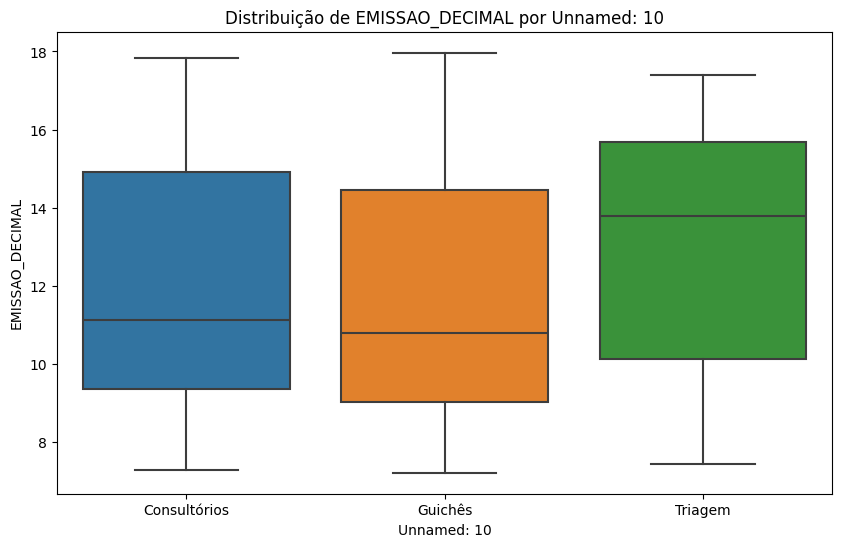

/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


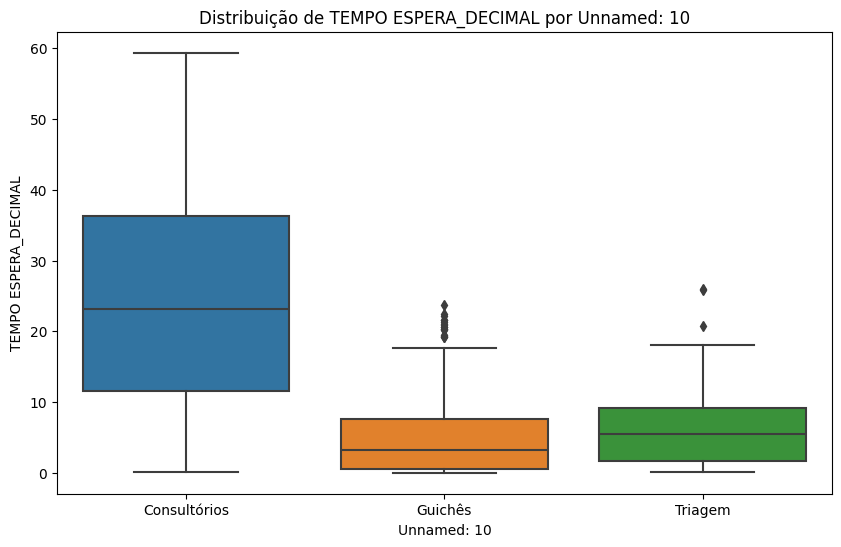

/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


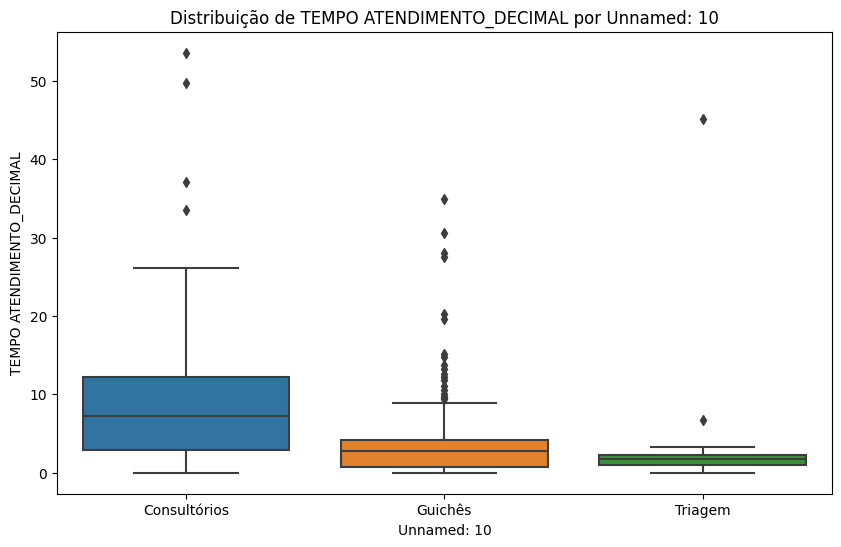

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que dfrelatorio_atendimento seja o seu DataFrame
# Crie um DataFrame contendo apenas as colunas relevantes
colunas_selecionadas = ['Unnamed: 10', 'EMISSAO_DECIMAL', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']
df_selecionado = dfrelatorio_atendimento[colunas_selecionadas]

# Agrupe por 'Unnamed: 10' e calcule estatísticas descritivas
estatisticas_descritivas = df_selecionado.groupby('Unnamed: 10').describe()

# Exiba a tabela de estatísticas descritivas
print(estatisticas_descritivas)

# Crie gráficos de caixa para cada coluna agrupada por 'Unnamed: 10'
for coluna in colunas_selecionadas[1:]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Unnamed: 10', y=coluna, data=df_selecionado)
    plt.title(f'Distribuição de {coluna} por Unnamed: 10')
    plt.show()

/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

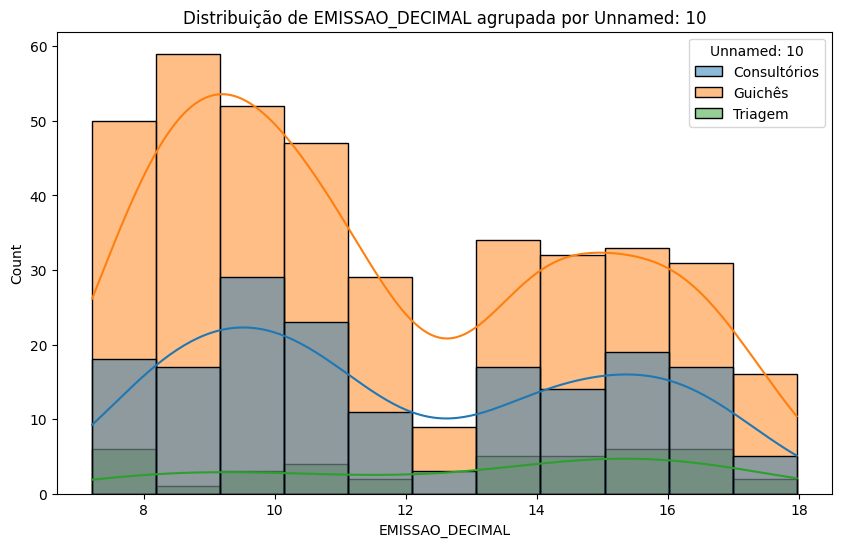

/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

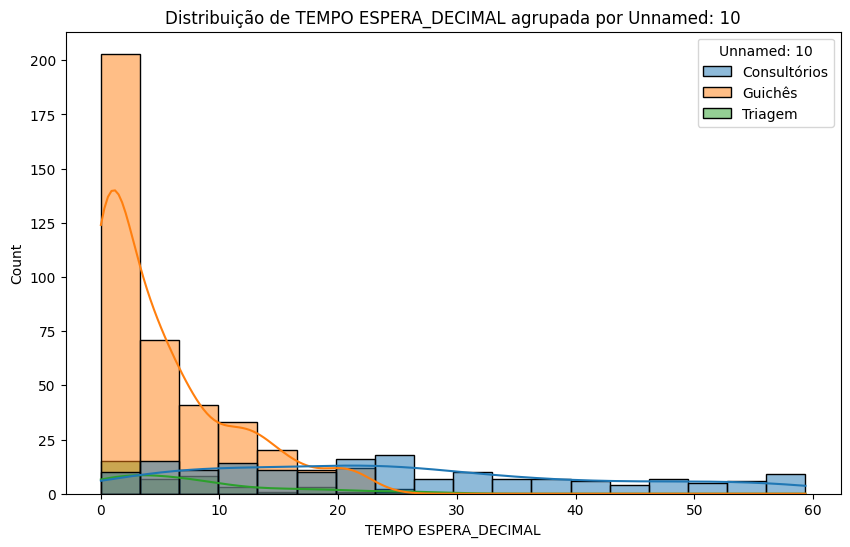

/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

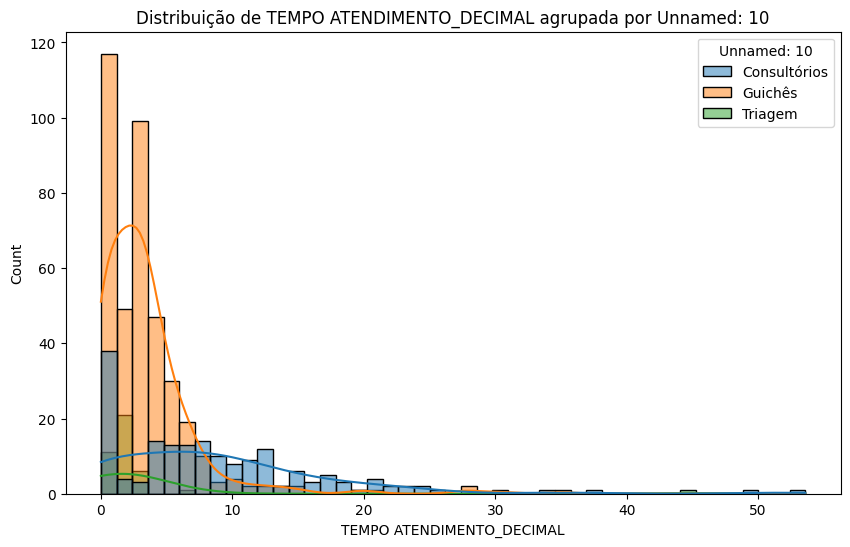

=== Resultados para EMISSAO_DECIMAL ===
Grupo Consultórios - Melhor distribuição: lognorm
Parâmetros da distribuição: (0.4715170217104003, 4.999721360515894, 6.30642610218481)
Estatísticas descritivas:
Grupo Guichês - Melhor distribuição: lognorm
Parâmetros da distribuição: (0.5191181543314582, 5.202614278474977, 5.7023591825195945)
Estatísticas descritivas:
Grupo Triagem - Melhor distribuição: expon
Parâmetros da distribuição: (7.441111111111111, 5.539381944444445)
Estatísticas descritivas:
=== Resultados para TEMPO ESPERA_DECIMAL ===
Grupo Consultórios - Melhor distribuição: expon
Parâmetros da distribuição: (0.05, 25.1723506743738)
Estatísticas descritivas:
Grupo Guichês - Melhor distribuição: norm
Parâmetros da distribuição: (5.148809523809524, 5.6399030342575625)
Estatísticas descritivas:
Grupo Triagem - Melhor distribuição: norm
Parâmetros da distribuição: (7.2887499999999985, 6.948297540784921)
Estatísticas descritivas:
=== Resultados para TEMPO ATENDIMENTO_DECIMAL ===
Grupo Con

In [113]:
from scipy.stats import norm, expon, gamma, weibull_min, lognorm, kstest
# Lista de colunas de interesse
colunas_decimais = ['EMISSAO_DECIMAL', 'TEMPO ESPERA_DECIMAL', 'TEMPO ATENDIMENTO_DECIMAL']

# Visualizando as distribuições usando seaborn
for coluna_decimal in colunas_decimais:
    plt.figure(figsize=(10, 6))
    sns.histplot(dfrelatorio_atendimento, x=coluna_decimal, hue='Unnamed: 10', kde=True, common_norm=False)
    plt.title(f'Distribuição de {coluna_decimal} agrupada por Unnamed: 10')
    plt.show()

# Teste de ajuste e estatísticas descritivas
distribuicoes = [norm, expon, gamma, weibull_min, lognorm]

for coluna_decimal in colunas_decimais:
    print(f"=== Resultados para {coluna_decimal} ===")
    for grupo, dados in dfrelatorio_atendimento.groupby('Unnamed: 10')[coluna_decimal]:
        melhor_distribuicao = None
        melhor_pvalue = float('inf')

        for distribuicao in distribuicoes:
            args = distribuicao.fit(dados)
            ks_statistic, pvalue = kstest(dados, distribuicao.cdf, args)

            if pvalue < melhor_pvalue:
                melhor_pvalue = pvalue
                melhor_distribuicao = distribuicao

        print(f"Grupo {grupo} - Melhor distribuição: {melhor_distribuicao.name}")
        print("Parâmetros da distribuição:", melhor_distribuicao.fit(dados))
        print("Estatísticas descritivas:")

In [98]:
df_cr = ('''
         select tccarhn.nome_paciente as CLIENTE, tccarhn.nome_procedimento, tccarhn."data" as DATA
from tb_consolidacao_contas_a_receber_hist_nova tccarhn 
where 1=1
and tccarhn.nome_procedimento like 'Consult%'
and tccarhn.nome_unidade = 'AmorSaúde Uberlândia'
''')

In [99]:
df = pd.read_sql_query(df_cr,con=connection)

/tmp/ipykernel_33304/3584572331.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(df_cr,con=connection)


In [100]:
novos_nomes = ['CLIENTE', 'PROCEDIMENTO', 'DATA']
df.columns = novos_nomes
df.dtypes

CLIENTE         object
PROCEDIMENTO    object
DATA            object
dtype: object

In [101]:
df1 = df

In [ ]:
df['DATA'] = pd.to_datetime(df['DATA'])
df.dtypes

In [103]:
df_merged = pd.merge(dfrelatorio_atendimento, df, on=['CLIENTE', 'DATA'], how='left')

In [104]:
contagem_vazios = df_merged1['PROCEDIMENTO'].isnull().sum()
contagem_vazios

296

In [105]:
contagem_procedimento = df_merged.groupby('Unnamed: 10')['PROCEDIMENTO'].count()
contagem_procedimento

Unnamed: 10
Consultórios    110
Guichês         137
Triagem          28
Name: PROCEDIMENTO, dtype: int64

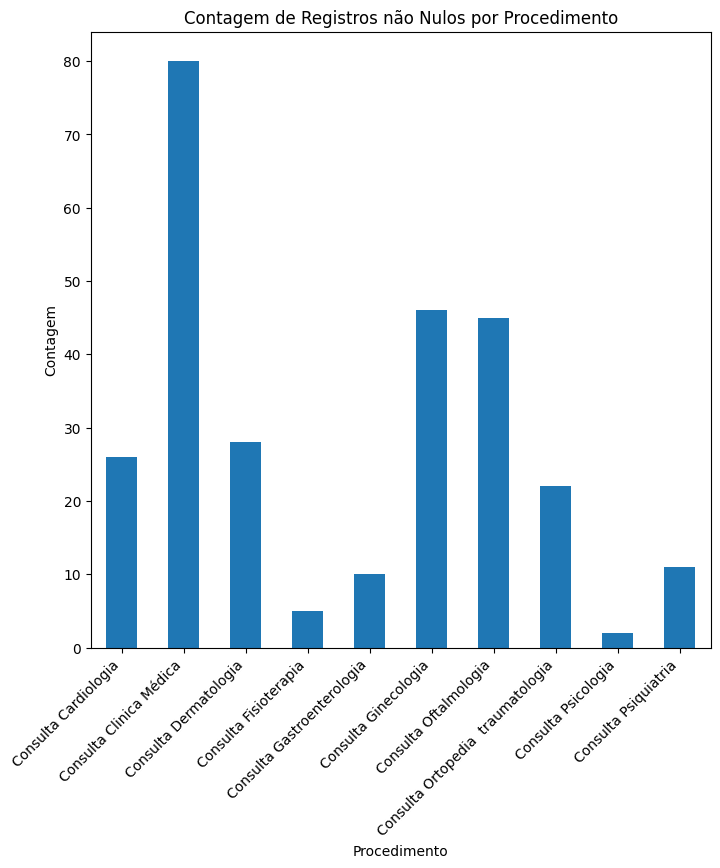

In [106]:
contagem_procedimento = df_merged.groupby('PROCEDIMENTO').size()
contagem_procedimento.plot(kind='bar', rot=0)
plt.title('Contagem de Registros não Nulos por Procedimento')
plt.xlabel('Procedimento')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')  # ha='right' ajusta a posição dos rótulos para evitar sobreposições
plt.show()

In [114]:
contagem_procedimento

PROCEDIMENTO
Consulta Cardiologia                 26
Consulta Clinica Médica              80
Consulta Dermatologia                28
Consulta Fisioterapia                 5
Consulta Gastroenterologia           10
Consulta Ginecologia                 46
Consulta Oftalmologia                45
Consulta Ortopedia  traumatologia    22
Consulta Psicologia                   2
Consulta Psiquiatria                 11
dtype: int64

/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

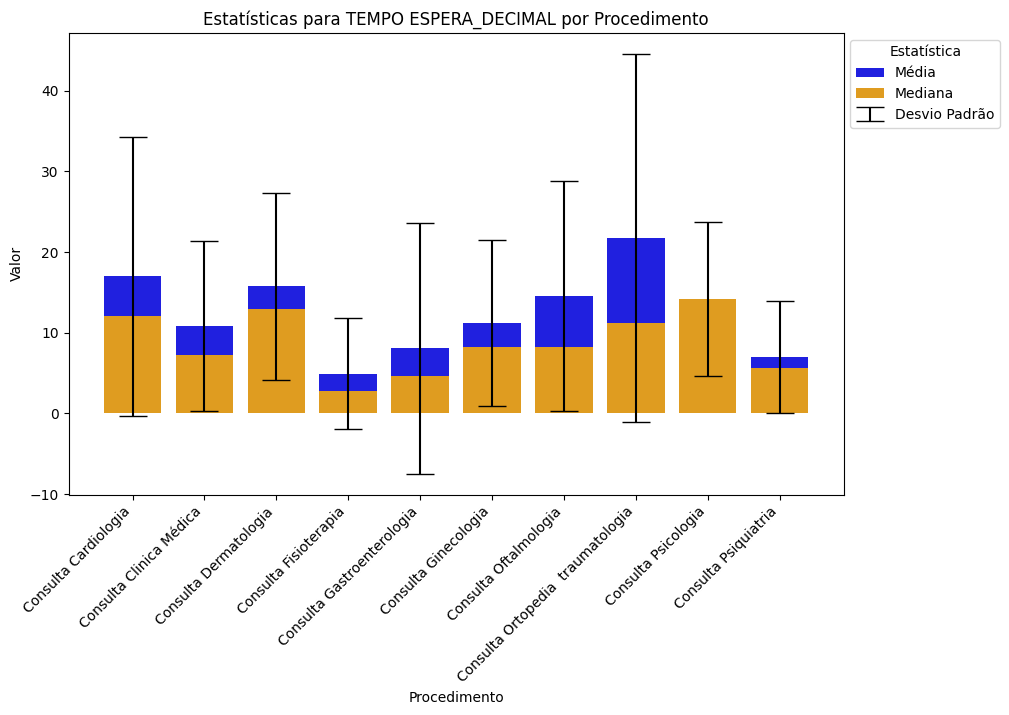

/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

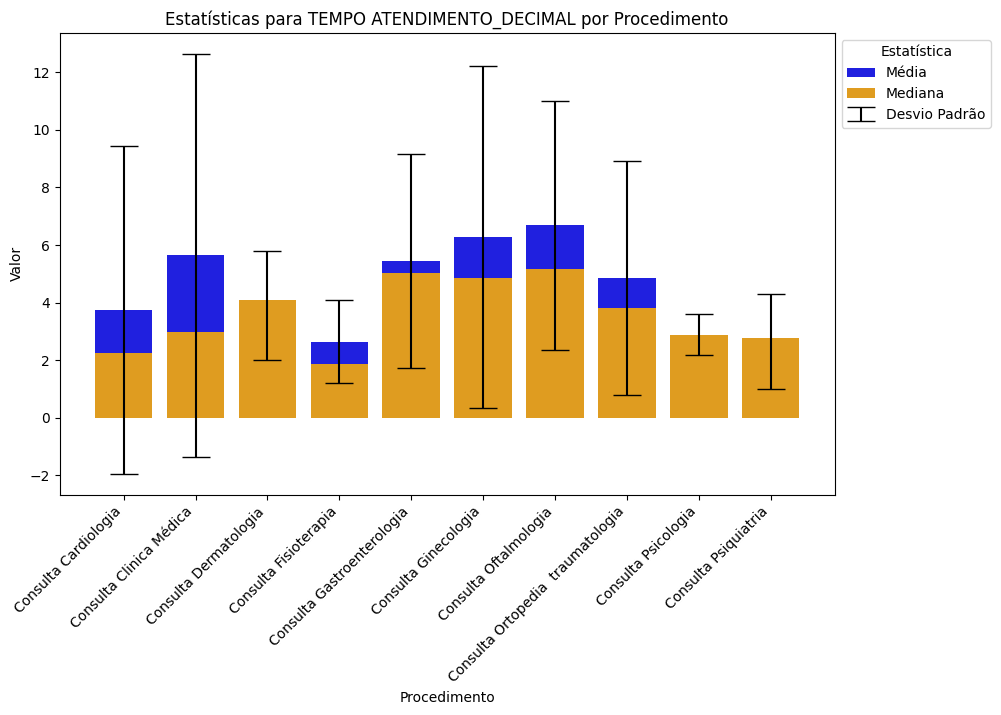

In [112]:
# Calcular média, mediana e desvio padrão para TEMPO ESPERA_DECIMAL
estatisticas_tempo_espera = df_merged.groupby('PROCEDIMENTO')['TEMPO ESPERA_DECIMAL'].agg(['mean', 'median', 'std'])

# Calcular média, mediana e desvio padrão para TEMPO ATENDIMENTO_DECIMAL
estatisticas_tempo_atendimento = df_merged.groupby('PROCEDIMENTO')['TEMPO ATENDIMENTO_DECIMAL'].agg(['mean', 'median', 'std'])

# Criar gráfico para TEMPO ESPERA_DECIMAL
plt.figure(figsize=(10, 6))
sns.barplot(x='PROCEDIMENTO', y='mean', data=estatisticas_tempo_espera.reset_index(), label='Média', color='blue')
sns.barplot(x='PROCEDIMENTO', y='median', data=estatisticas_tempo_espera.reset_index(), label='Mediana', color='orange')
plt.errorbar(x=estatisticas_tempo_espera.reset_index()['PROCEDIMENTO'], y=estatisticas_tempo_espera['mean'], yerr=estatisticas_tempo_espera['std'], fmt='none', color='black', capsize=10, label='Desvio Padrão')
plt.title('Estatísticas para TEMPO ESPERA_DECIMAL por Procedimento')
plt.xlabel('Procedimento')
plt.ylabel('Valor')
plt.legend(title='Estatística', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')  # ha='right' ajusta a posição dos rótulos para evitar sobreposições
plt.show()

# Criar gráfico para TEMPO ATENDIMENTO_DECIMAL
plt.figure(figsize=(10, 6))
sns.barplot(x='PROCEDIMENTO', y='mean', data=estatisticas_tempo_atendimento.reset_index(), label='Média', color='blue')
sns.barplot(x='PROCEDIMENTO', y='median', data=estatisticas_tempo_atendimento.reset_index(), label='Mediana', color='orange')
plt.errorbar(x=estatisticas_tempo_atendimento.reset_index()['PROCEDIMENTO'], y=estatisticas_tempo_atendimento['mean'], yerr=estatisticas_tempo_atendimento['std'], fmt='none', color='black', capsize=10, label='Desvio Padrão')
plt.title('Estatísticas para TEMPO ATENDIMENTO_DECIMAL por Procedimento')
plt.xlabel('Procedimento')
plt.ylabel('Valor')
plt.legend(title='Estatística', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')  # ha='right' ajusta a posição dos rótulos para evitar sobreposições
plt.show()
